Mandelbrot created in 0.142024 s


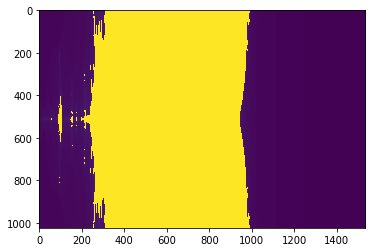

In [10]:
from __future__ import print_function, division, absolute_import


from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np
from numba import jit

@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.7, -0.1, 0.1, image, 20) 
dt = timer() - start

print( "Mandelbrot created in %f s" % dt)
imshow(image)
# show()

In [100]:
import cupy as cp
from numba import jit

@jit(parallel=True)
def np_add(x,y):
    return x+y

# @jit
def cp_add(x,y):
    return x+y
a=np.linspace(1,10)
b=np.linspace(-1,1)
x=cp.asarray(a)
y=cp.asarray(b)

print("cpu:", np_add(a,b))
%timeit np_add(a,b)
print("gpu: ",cp_add(x,y))
%timeit cp_add(x,y)

cpu: [ 0.          0.2244898   0.44897959  0.67346939  0.89795918  1.12244898
  1.34693878  1.57142857  1.79591837  2.02040816  2.24489796  2.46938776
  2.69387755  2.91836735  3.14285714  3.36734694  3.59183673  3.81632653
  4.04081633  4.26530612  4.48979592  4.71428571  4.93877551  5.16326531
  5.3877551   5.6122449   5.83673469  6.06122449  6.28571429  6.51020408
  6.73469388  6.95918367  7.18367347  7.40816327  7.63265306  7.85714286
  8.08163265  8.30612245  8.53061224  8.75510204  8.97959184  9.20408163
  9.42857143  9.65306122  9.87755102 10.10204082 10.32653061 10.55102041
 10.7755102  11.        ]
32.6 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
gpu:  [ 0.          0.2244898   0.44897959  0.67346939  0.89795918  1.12244898
  1.34693878  1.57142857  1.79591837  2.02040816  2.24489796  2.46938776
  2.69387755  2.91836735  3.14285714  3.36734694  3.59183673  3.81632653
  4.04081633  4.26530612  4.48979592  4.71428571  4.93877551  5.16326531
  5.3877551  